# Exact GP playground: Linear Alkanes

In [90]:
%load_ext autoreload
%autoreload 2

import torch
import malt
import abc
import gpytorch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Testing GPyTorch API

In [91]:
torch.manual_seed(10)

In [111]:
from malt.models.regressor import GPyTorchExactRegressor
from malt.data.collections import linear_alkanes, esol

# get data
# data = linear_alkanes()
data = esol()
data.shuffle()

# make dataset bigger ....

train_x, train_y = data.batch()
# train_y = train_y.ravel()

# create model
model = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=32, hidden_features=32,
    ),
    regressor=GPyTorchExactRegressor(
        in_features=32,
        out_features=2,
        train_targets=train_y,
    ),
    likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
).cuda()

# define marginal log likelihood
from malt.models.marginal_likelihood import ExactMarginalLogLikelihood

mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.regressor.likelihood, model)

# define optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=1e-3)

Processing dgl graphs from scratch...
Processing molecule 1000/1128


In [116]:
from tqdm import tqdm
def train(model, optimizer, mll):
    loss_history = []
    train_iter = 200
    model.train()
    for i in tqdm(range(train_iter)):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y).mean()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    return model, loss_history

In [113]:
def test(model, test_x, test_y):
    from scipy.stats import pearsonr
    model.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        preds = model(test_x)
    rmse = torch.sqrt(torch.mean(torch.pow(preds.mean - test_y, 2))).item()
    mae = torch.mean(torch.abs(preds.mean - test_y)).item()
    corr, _ = pearsonr(preds.mean.tolist(), test_y.tolist())
    r2 = malt.metrics.base_metrics.r2(preds.loc, test_y).item()
    return rmse, mae, corr, r2

In [114]:
model.train()
model, loss_history = train(model, optimizer, mll)
model.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(train_x).loc
rmse, mae, corr, r2 = test(model, train_x, train_y)
print('rmse:', rmse, '\nmae:', mae, '\ncorr:', corr, '\nr2:', r2)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.79it/s]


rmse: 2.860219955444336 
mae: 2.2645556926727295 
corr: [0.9536872206965642] 
r2: 0.9015082716941833


Text(0.5, 1.0, 'gpytorch: training')

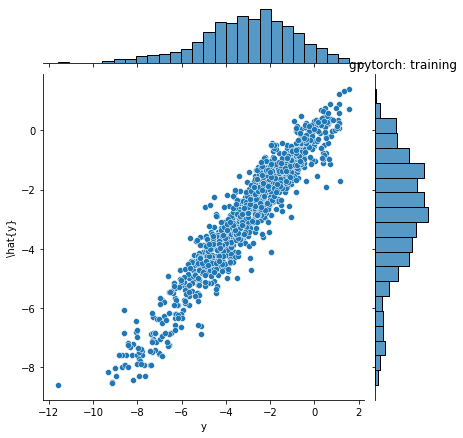

In [115]:
model.eval()

import seaborn as sns

preds = model(train_x)

g = sns.jointplot(x = train_y.ravel().tolist(), y = (preds.loc).tolist())
g.set_axis_labels('y', '\hat{y}')
plt.title('gpytorch: training')

### Testing hard-coded API

In [117]:
model = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=32, hidden_features=32,
    ),
    regressor=malt.models.regressor.ExactGaussianProcessRegressor(
        train_targets=train_y,
    ),
    # likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
).cuda()

In [118]:
# define marginal log likelihood
from malt.models.marginal_likelihood import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(model.likelihood, model)

# define optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=1e-3)

In [119]:
model, loss_history = train(model, optimizer, mll)
model.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(train_x).loc
rmse, mae, corr, r2 = test(model, train_x, train_y)
print('rmse:', rmse, '\nmae:', mae, '\ncorr:', corr, '\nr2:', r2)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.28it/s]


rmse: 2.941166400909424 
mae: 2.33052921295166 
corr: [0.9984399032683122] 
r2: 0.996692419052124


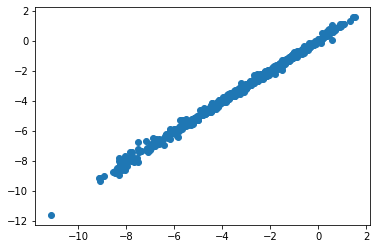

In [120]:
model.eval()
import matplotlib.pyplot as plt

plt.scatter(
    model(train_x).loc.tolist(),
    train_y.tolist(),
)